# Import some packages

In [520]:
import os
import numpy as np
import pandas as pd
import pandas as pd
import shutil
import time
from copy import deepcopy

device = 'cuda'
import torchvision.models as models
from tqdm.notebook import tqdm

In [521]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split

# Load data

In [523]:
train_df = pd.read_csv("../data/nesp-9936-unique-mutations-voxel-features/dataset.csv")
test_df = pd.read_csv("../data/kaggle/test.csv")
test_df.rename(columns={'protein_sequence': 'sequence'}, inplace=True)

# Transforming 
This will convert each protein sequence (a list of amino acids) to a matrix, where each row is the physical and chemical properties of the corresponding amino acid

In [524]:
df_aa = pd.read_csv("../data/aminoacids.csv")
transform_dict = {}
"""
0 = Name (Ignore)
1 = Abbr (Ignore)
2 = Letter
3 = Molecular Weight
4 = Molecular Formula (Ignore)
5 = Residue Formula (Ignore)
6 = Residue Weight 
7 = pKa1 -> positively correlated to polarity
8 = pKb2 -> positively correlated to polarity
9 = pKx3 -> positively correlated to polarity
10 = pl4
11 = H
12 = VSC
13 = P1
14 = P2
15 = SASA
16 = NCISC
17 = carbon
18 = hydrogen
19 = nitrogen
20 = oxygen
21 = sulfur
"""
feature_list = [3, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
df_aa.iloc[:, feature_list] = (df_aa.iloc[:, feature_list] - df_aa.iloc[:, feature_list].mean()) / df_aa.iloc[:, feature_list].std()
df_aa = df_aa.fillna(0)

In [525]:
# feature_list chooses which physical and chemical properties to inlcude
def getTransformDict(feature_list = [3, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]):
  transform_dict = {}
  for index, row in df_aa.iterrows():
    row_values = row.values
    letter = row_values[2]
    the_rest = [row_values[i] for i in feature_list]
    transform_dict.update({letter: np.array(the_rest, dtype="float")})
  transform_dict.update({None: np.zeros(shape=len(feature_list),dtype="float")})
  transform_dict.update({'X': np.zeros(shape=len(feature_list),dtype="float")})
  return transform_dict

In [526]:
# convert list of amino acids into a matrix of their corresponding physical and chemical properties
def convertSequences(sequences, MAX_LENGTH, transform_dict=None):
  if transform_dict is None:
    transform_dict = getTransformDict()
  sequenceList = []
  # print(sequences)
  for sequence in sequences:
    letterMatrix = []
    for i in range(MAX_LENGTH):
      if i < len(sequence):
        letterMatrix.append(transform_dict[sequence[i]])
      else:
        letterMatrix.append(transform_dict[None])
    sequenceList.append(np.array(letterMatrix))
  return sequenceList

In [527]:
def getSequences(df, MAX_LENGTH=224):
  # df.reset_index(inplace=True)
  sequences = [list(string) for string in df["sequence"].values.tolist()]
  return convertSequences(sequences, MAX_LENGTH)

In [528]:
def filterDataFrame(df, MIN_LENGTH=100, MAX_LENGTH=224):
    df["protein_sequence_len"] = df["sequence"].apply(lambda x: len(x))
    df = df[df["protein_sequence_len"] <= MAX_LENGTH]
    df = df[df["protein_sequence_len"] >= MIN_LENGTH]
    if 'dT' in df:
        print("Standardizing dT")
        df['dT'] = (df['dT'] - df['dT'].mean())/df['dT'].std()
    if 'ddG' in df:
        print("Standardizing ddG")
        df['ddG'] = (df['ddG'] - df['ddG'].mean())/df['ddG'].std()
    return df

In [529]:
from sklearn.model_selection import train_test_split

MAX_LENGTH = 224
MIN_LENGTH = 100
train_df = filterDataFrame(train_df, MIN_LENGTH=MIN_LENGTH, MAX_LENGTH=MAX_LENGTH)
print(train_df.shape)
X = getSequences(train_df, MAX_LENGTH=MAX_LENGTH)
y = train_df[['ddG', 'dT']].values


X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

Standardizing dT
Standardizing ddG
(5205, 12)


In [530]:
test_df = filterDataFrame(test_df, MIN_LENGTH=MIN_LENGTH, MAX_LENGTH=MAX_LENGTH)
X_test = getSequences(test_df)

## Loading and normalizing

In [531]:
def toTensor(array):
    tensor = torch.Tensor(np.array(array))
    # return tensor
    return tensor.view(tensor.size(dim=0), 1, tensor.size(dim=1), tensor.size(dim=2))

In [532]:
import tensorflow as tf
from torch.utils.data import TensorDataset, DataLoader
trainset = TensorDataset(toTensor(X_train), torch.Tensor(y_train))
valset = TensorDataset(toTensor(X_val), torch.Tensor(y_val))
testset = TensorDataset(toTensor(X_test), torch.Tensor(np.zeros(shape=len(X_test))))

#TODO: revise batch_size
BATCH_SIZE = 32
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# Define the model

In [533]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten()
        )
        self.fc1_dT = nn.Sequential(
            nn.Linear(64 * 108, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
        )
        self.fc2_dT = nn.Sequential(
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
        )
        self.fc3_dT = nn.Sequential(
            nn.Linear(512, 1),
        )


        self.fc1_ddG = nn.Sequential(
            nn.Linear(64 * 108, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
        )
        self.fc2_ddG = nn.Sequential(
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
        )
        self.fc3_ddG = nn.Sequential(
            nn.Linear(512, 1),
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        ddg = self.fc1_ddG(x)
        ddg = self.fc2_ddG(ddg)
        ddg = self.fc3_ddG(ddg)
        dT = self.fc1_dT(x)
        dT = self.fc2_dT(dT)
        dT = self.fc3_dT(dT)
        return ddg.squeeze(), dT.squeeze()

In [534]:
model = Net().to(device)

In [535]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.7)

# Define the Training Functions

In [536]:
# %%time
best_val_loss = 100000
best_val_model = None
MAX_EPOCH = 20
loss_record = {'train': [], 'dev': []} # added
C_dt_loss = 0.01
for epoch in range(MAX_EPOCH):  
    model.train()
    running_train_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()
        # print(labels)
        ddg = labels[:, 0]
        dt = labels[:, 1]

        optimizer.zero_grad()
        ddg_pred, dt_pred = model(inputs)
        
        loss = None
        any_ddg = ~torch.isnan(ddg)
        if torch.any(any_ddg):
            loss = criterion(ddg[any_ddg], ddg_pred[any_ddg])
        any_dt = ~torch.isnan(dt)
        if torch.any(any_dt):
            dt_loss = criterion(dt[any_dt], dt_pred[any_dt])
            if loss is None:
                loss = dt_loss * C_dt_loss
            else:
                loss += dt_loss * C_dt_loss
        loss.backward()
        optimizer.step()

        # print statistics
        running_train_loss += loss.item()
    loss_record['train'].append(running_train_loss/len(trainset))
    
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for inputs,labels in valloader:
            ddg = labels[:, 0]
            dt = labels[:, 1]
            ddg_pred, dt_pred = model(inputs.cuda())
            ddg_pred, dt_pred = ddg_pred.cpu(), dt_pred.cpu()
            ddg_pred, dt_pred = ddg_pred.detach(), dt_pred.detach()
            not_nan_ddg = ~torch.isnan(ddg)
            ddg_loss = criterion(ddg[not_nan_ddg], ddg_pred[not_nan_ddg])

            not_nan_dt = ~torch.isnan(dt)
            dt_loss = criterion(dt[not_nan_dt], dt_pred[not_nan_dt])

            loss = torch.stack([ddg_loss, dt_loss * C_dt_loss])
            loss = loss[~torch.isnan(loss)].sum()
            running_val_loss += loss.item()
    loss_record['dev'].append(running_val_loss/len(valset))
    print("Epoch [{:>2} / {}]: Train loss = {:<25} Val Loss = {:<25}".format(epoch+1, MAX_EPOCH, running_train_loss/len(trainset), running_val_loss/len(valset)))
    if running_val_loss < best_val_loss:
        best_val_loss = running_val_loss
        best_val_model = deepcopy(model.state_dict())
    lr_scheduler.step()
    
print('Finished Training')

Epoch [ 1 / 20]: Train loss = 0.032060946213523435      Val Loss = 0.02800665479457573      
Epoch [ 2 / 20]: Train loss = 0.027985327489724193      Val Loss = 0.027711501468499045     
Epoch [ 3 / 20]: Train loss = 0.028026936706388145      Val Loss = 0.028404646516418823     
Epoch [ 4 / 20]: Train loss = 0.02739571413520892       Val Loss = 0.028909538023524507     
Epoch [ 5 / 20]: Train loss = 0.027143573698003513      Val Loss = 0.02610135198670093      
Epoch [ 6 / 20]: Train loss = 0.02657868023908104       Val Loss = 0.02682515855710399      
Epoch [ 7 / 20]: Train loss = 0.026144230722178644      Val Loss = 0.02825697268807579      
Epoch [ 8 / 20]: Train loss = 0.0263134034549125        Val Loss = 0.028539255418878237     
Epoch [ 9 / 20]: Train loss = 0.02639974363856769       Val Loss = 0.027150944748483632     
Epoch [10 / 20]: Train loss = 0.026430852439229473      Val Loss = 0.02880334321634914      
Epoch [11 / 20]: Train loss = 0.02573523369835158       Val Loss = 0.0

# Learning Curve

In [537]:
# For plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import math

In [538]:
def plot_learning_curve(record, title=''):
    ''' Plot learning curve of your DNN (train & dev loss) '''
    x_1 = range(len(record['train']))
    x_2 = range(len(record['dev']))
    figure(figsize=(6, 4))
    plt.plot(x_1, record['train'], c='tab:red', label='train')
    plt.plot(x_2, record['dev'], c='tab:cyan', label='dev')
    
    # TODO: feel free to change this range to see the learning curve better
    y_min = min(min(record['train']), min(record['dev']))
    y_max = max(max(record['train']), max(record['dev']))
    plt.ylim(max(.95*y_min-0.01, 0), 1.05*y_max+0.01)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()

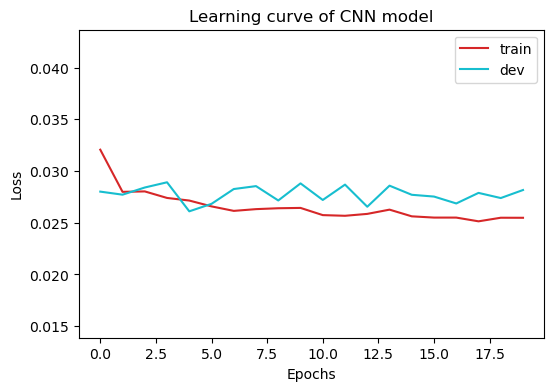

In [539]:
plot_learning_curve(loss_record, title="CNN model")

# Model Evaluation and Prediction

In [540]:
%%time
preds = []
model.load_state_dict(best_val_model)
model.eval()
with torch.no_grad():
    for inputs, labels in testloader:
        ddg_pred, dt_pred = model(inputs.cuda())
        preds.append(ddg_pred.detach().cpu())
preds = torch.cat(preds, dim=0).numpy()

Wall time: 2.4 s


In [541]:
def make_prediction(preds, file):
    print(f'Saving results to {file}')
    submission = pd.read_csv("../data/kaggle/sample_submission.csv")
    submission["tm"] = preds
    submission.to_csv(file, index=False)

make_prediction(preds, file="pred_v2.csv")

Saving results to pred_v2.csv
